In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchsummary import summary
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [4]:
!pip install torchsummary

In [5]:

# Define MobileNetV2 model
mobilenet = models.mobilenet_v2(pretrained=True)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet.to(device)

# Print model summary
summary(mobilenet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))])

In [7]:
train_dir= '/content/drive/MyDrive/Project/plant_dataset/Train/Train'
test_dir = '/content/drive/MyDrive/Project/plant_dataset/Test/Test'
val_dir= '/content/drive/MyDrive/Project/plant_dataset/Validation/Validation'
test_set = datasets.ImageFolder(root=test_dir, transform=transform)
train_set = datasets.ImageFolder(root=train_dir, transform=transform)
val_set = datasets.ImageFolder(root=val_dir, transform=transform)

In [8]:
# Assuming you have three datasets: train_set, test_set, and val_set
# Get the class-to-indices mapping for each dataset
class_to_idx_train = train_set.class_to_idx
class_to_idx_test = test_set.class_to_idx
class_to_idx_val = val_set.class_to_idx

# Create dictionaries to store class counts for each dataset
class_count_train = {class_name: 0 for class_name in class_to_idx_train.keys()}
class_count_test = {class_name: 0 for class_name in class_to_idx_test.keys()}
class_count_val = {class_name: 0 for class_name in class_to_idx_val.keys()}

# Count the total number of images in each class within each dataset
for _, class_idx in train_set.samples:
    class_name = [key for key, value in class_to_idx_train.items() if value == class_idx][0]
    class_count_train[class_name] += 1

for _, class_idx in test_set.samples:
    class_name = [key for key, value in class_to_idx_test.items() if value == class_idx][0]
    class_count_test[class_name] += 1

for _, class_idx in val_set.samples:
    class_name = [key for key, value in class_to_idx_val.items() if value == class_idx][0]
    class_count_val[class_name] += 1

# Print the total number of images in each class for each dataset
for class_name, count in class_count_train.items():
    print("TRAIN DATASET:")
    print(f"Class '{class_name}': {count} images")

for class_name, count in class_count_test.items():
    print("TEST DATASET:")
    print(f"Class '{class_name}': {count} images")

for class_name, count in class_count_val.items():
    print("VALIDATION DATASET:")
    print(f"Class '{class_name}': {count} images")

TRAIN DATASET:
Class 'Healthy': 458 images
TRAIN DATASET:
Class 'Powdery': 430 images
TRAIN DATASET:
Class 'Rust': 434 images
TEST DATASET:
Class 'Healthy': 50 images
TEST DATASET:
Class 'Powdery': 50 images
TEST DATASET:
Class 'Rust': 50 images
VALIDATION DATASET:
Class 'Healthy': 20 images
VALIDATION DATASET:
Class 'Powdery': 20 images
VALIDATION DATASET:
Class 'Rust': 20 images


- The keys, 'class_1', 'class_2', and 'class_3', represent the class names or labels.
- The values, 100, 150, and 120, represent the counts or frequencies of training data samples associated with each class.
- ***The tight_layout()*** function in Matplotlib is used to automatically adjust the spacing between subplots or other elements within a figure to make the plot more visually appealing and readable.

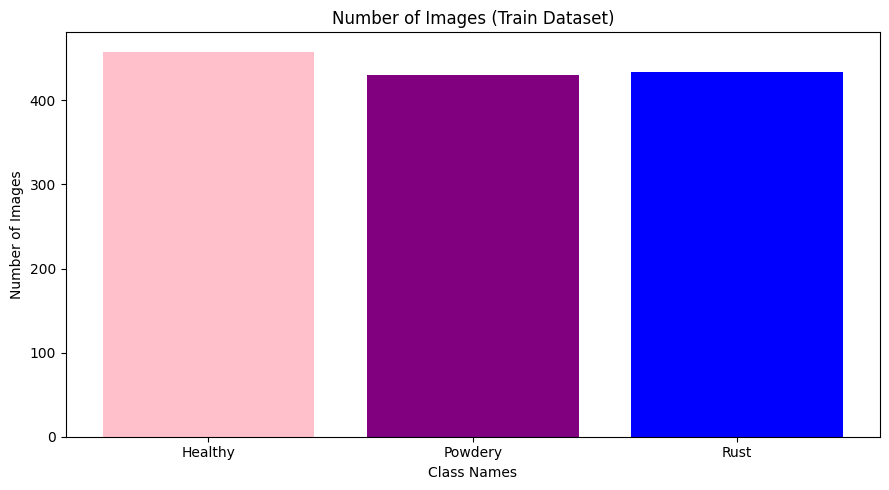

In [9]:
class_names= list(class_count_train.keys())
images_count= list(class_count_train.values())
# creating a bar graph
plt.figure(figsize=(9,5))
colors=['pink', 'purple', 'blue']
plt.bar(class_names, images_count, color=colors)

plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.title('Number of Images (Train Dataset)')
plt.tight_layout()
plt.show()

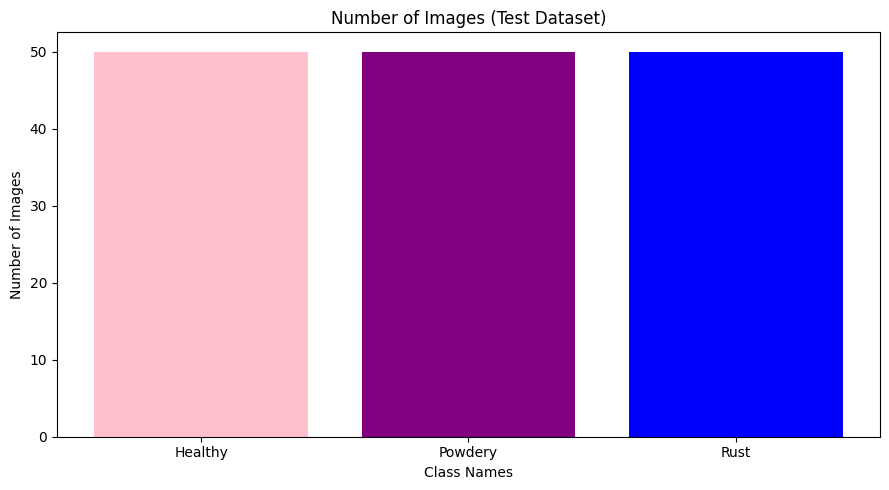

In [10]:
class_names= list(class_count_test.keys())
images_count= list(class_count_test.values())
# creating a bar graph
plt.figure(figsize=(9,5))
colors=['pink', 'purple', 'blue']
plt.bar(class_names, images_count, color=colors)

plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.title('Number of Images (Test Dataset)')
plt.tight_layout()
plt.show()

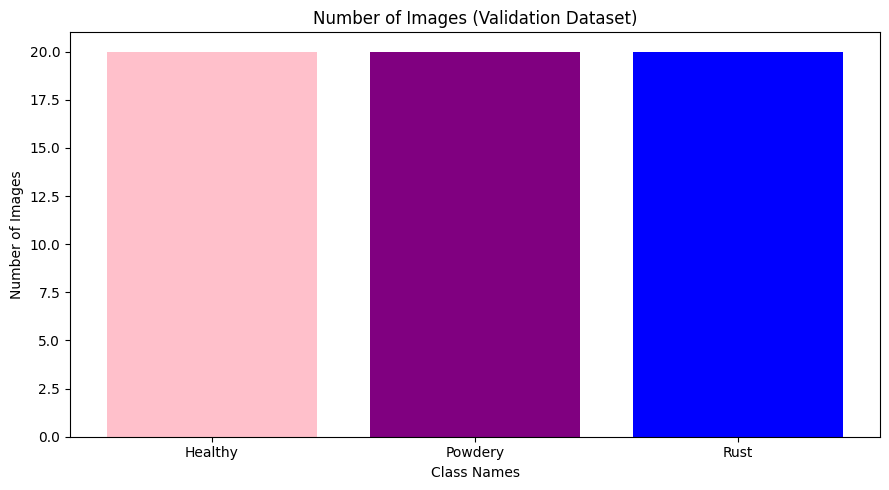

In [11]:
class_names= list(class_count_val.keys())
images_count= list(class_count_val.values())
# creating a bar graph
plt.figure(figsize=(9,5))
colors=['pink', 'purple', 'blue']
plt.bar(class_names, images_count, color=colors)

plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.title('Number of Images (Validation Dataset)')
plt.tight_layout()
plt.show()

- ***num_train = int(train_ratio * num_samples):*** This line calculates the number of samples that will be used for training. It does this by multiplying the train_ratio (a fraction between 0 and 1) by the total number of samples (num_samples). The result is then converted to an integer using int(). This gives the number of training samples.
- ***num_val = int(val_ratio * num_samples):*** Similarly, this line calculates the number of samples that will be used for validation. It multiplies the val_ratio by the total number of samples (num_samples) and converts the result to an integer. This gives the number of validation samples.
- ***num_test = num_samples - num_train - num_val:*** Finally, this line calculates the number of samples that will be used for testing.

In [12]:
# Define the split ratios (adjust as needed)
train_ratio = 0.8  # 80% for training
val_ratio = 0.1    # 10% for validation, the remaining 10% will be for testing

# Calculate the sizes of each split
num_samples = len(train_set) # calculates the total number of samples in your train_set dataset by using the len() function.
num_train = int(train_ratio * num_samples)
num_val = int(val_ratio * num_samples)
num_test = num_samples - num_train - num_val

In [13]:
# Use torch.utils.data.random_split to split the dataset
train_set, val_set, test_set = torch.utils.data.random_split(
    train_set, [num_train, num_val, num_test]
)

In [14]:

# Create data loaders for training, validation, and testing
batch_size =64
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


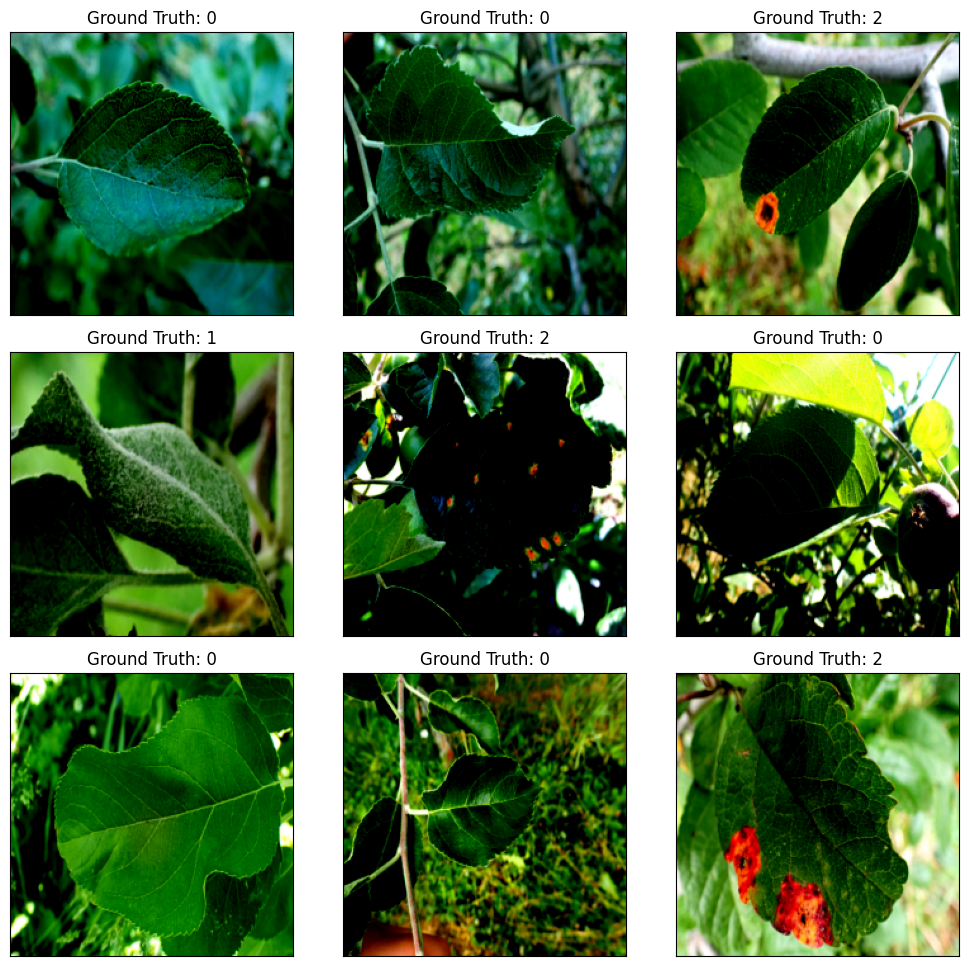

In [15]:
sample_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
sample_batch = next(iter(sample_loader))
sample_images = sample_batch[0]
sample_targets = sample_batch[1]  # Get the ground truth labels for the batch

# Visualize the first 6 sample images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.tight_layout()
    plt.imshow(sample_images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.title("Ground Truth: {}".format(sample_targets[i]))  # Display the actual ground truth label
    plt.xticks([])
    plt.yticks([])

plt.show()


In [16]:

# Get the total number of batches
total_batches = len(trainloader)
print(f"Total number of batches: {total_batches}")
total_batches = len(testloader)
print(f"Total number of batches: {total_batches}")
total_batches = len(valloader)
print(f"Total number of batches: {total_batches}")

Total number of batches: 17
Total number of batches: 3
Total number of batches: 3


In [17]:
from PIL import Image

# Load the first image from your dataset
image = Image.open('/content/drive/MyDrive/Project/plant_dataset/Validation/Validation/Healthy/9bd4cc8c52e9d52a.jpg')
image_size = image.size
print("Image size:", image_size)


Image size: (4000, 2672)


In [18]:

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

- ***Gradient computations*** is essential for updating the model's weights and biases through backpropagation. During training, you want to compute gradients for all model parameters to perform gradient descent and update the model's weights to minimize the loss.
- ***torch.no_grad()*** is mainly used during the evaluation and inference phases to save memory and computation. During training, you should not use it because you want to compute gradients for parameter updates.

In [ ]:

def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
# Initialize an empty list to store training losses
training_losses = []

# Training loop with validation
num_epochs = 10
from tqdm import tqdm
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    model.train()

    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train

    # Append the training loss to the list
    training_losses.append(running_loss / len(trainloader))

    model.eval()  # Set the network to evaluation mode for validation
    correct_val = 0
    total_val = 0

    for val_data in valloader:
        val_images, val_labels = val_data
        val_outputs = model(val_images)
        _, val_predicted = torch.max(val_outputs.data, 1)
        total_val += val_labels.size(0)
        correct_val += (val_predicted == val_labels).sum().item()

    accuracy_val = 100 * correct_val / total_val
    print(f"[Epoch {epoch + 1}] Training Loss: {running_loss / len(trainloader):.3f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy_val:.2f}%")

print("Finished Training")


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:

# Testing
correct_test = 0
total_test = 0
model.eval()  # Set the network to evaluation mode for testing

with torch.no_grad():
    for test_data in testloader:
        test_images, test_labels = test_data
        test_outputs = model(test_images)
        _, test_predicted = torch.max(test_outputs.data, 1)
        total_test += test_labels.size(0)
        correct_test += (test_predicted == test_labels).sum().item()

accuracy_test = 100 * correct_test / total_test
print(f"Test Accuracy: {accuracy_test:.2f}%")


In [ ]:
import torch.nn.functional as F
# Set the network to evaluation mode
model.eval()

# Forward pass the sample images through the network
with torch.no_grad():
    outputs = model(sample_images)

# Get the predicted labels (class with the highest probability)
predicted_labels = torch.argmax(F.softmax(outputs, dim=1), dim=1)

# Visualize the first 9 sample images along with their ground truth and predicted labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.tight_layout()
    plt.imshow(sample_images[i].permute(1, 2, 0).numpy())  # Convert to NumPy array for visualization
    plt.title("Ground Truth: {}\nPredicted: {}".format(sample_targets[i], predicted_labels[i]))
    plt.xticks([])
    plt.yticks([])

plt.show()

In [ ]:

# Define a function to evaluate the model and create confusion matrix and classification report
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
    cm = confusion_matrix(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions)
    return cm, report

# Calculate the confusion matrix and classification report for the validation set
val_confusion_matrix, val_classification_report = evaluate_model(model, valloader)

# Calculate the confusion matrix and classification report for the test set
test_confusion_matrix, test_classification_report = evaluate_model(model, testloader)

In [ ]:

# Plot the training loss graph
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), training_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Display the confusion matrices
print("Validation Confusion Matrix:")
print(val_confusion_matrix)

print("\nTest Confusion Matrix:")
print(test_confusion_matrix)

In [ ]:

print("\nValidation Classification Report:")
print(val_classification_report)
print("\nTest Classification Report:")
print(test_classification_report)

In [ ]:
import seaborn as sns

# Define your class names as a list
class_names = ["Class Net"]

# Define a function to plot a confusion matrix
def plot_confusion_matrix(confusion_matrix, class_names, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Plot the validation confusion matrix
plot_confusion_matrix(val_confusion_matrix, class_names, "Validation Confusion Matrix")

In [ ]:

# Plot the test confusion matrix
plot_confusion_matrix(test_confusion_matrix, class_names, "Test Confusion Matrix")
